# <center> Amazon Product Recommendation</center>
### Problem Statement
Online E-commerce websites like Amazon, Filpkart uses different recommendation models to provide different suggestions to different users. 

When shopping on E-commerce platforms, customers may be faced with a bunch of irrelevant recommended products which could possibly divert them out from the shopping platform. Understanding consumer preferences and leveraging on it to retain them in the site could increase the likelihood of them purchasing an item.

### Objective : 
To recommend users a list of similar products in the same category based on the current product they are browsing.

In this project we are going to build recommendation model for the electronics products of Amazon.

### Dataset

The columns in this dataset are:

- **userId**
- **productId**
- **ratings**
- **timestamp**

---
### Imports and Configurations

In [39]:
# Utilities
import math, random, warnings
from time import time
from datetime import datetime
from collections import defaultdict
from IPython.core.interactiveshell import InteractiveShell

# Mathematical calculation
import numpy as np
from scipy.sparse.linalg import svds
from sklearn import model_selection
from sklearn.metrics.pairwise import cosine_similarity

# Data handling
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [40]:
# Configure for any default setting of any library
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [41]:
# Load the dataset into a Pandas dataframe called ratings
file_path = "ratings_Electronics.csv"

# Determine the total number of rows in the dataset
total_rows = sum(1 for line in open(file_path))

rows = total_rows
ratings = pd.read_csv(file_path, nrows=rows,names=['userId', 'productId', 'rating', 'timestamp'], )


In [42]:
# Check the head of the dataset
ratings.head()
# Check the tail of the dataset
ratings.tail()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.000,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.000,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.000,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.000,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.000,1334707200


,userId,productId,rating,timestamp
1956115,A265FGO91ZJVXO,B001E91OCO,5.000,1262908800
1956116,A1XR6SP8HZNV39,B001E91OCO,5.000,1236038400
1956117,AO5NHIDVIBLGR,B001E91OCO,5.000,1235433600
1956118,AVIL6LECXBWTC,B001E91OCO,5.000,1231459200
1956119,A2YG98R120QQJ2,B001E91OCO,5.000,1235433600



### Inspect the Dataset

In [43]:
# Get the shape and size of the dataset
print("Number of rows    :",ratings.shape[0])
print("Number of columns :",ratings.shape[1])

Number of rows    : 1956120
Number of columns : 4


In [44]:
# Get more info on it
# 1. Name of the columns
# 2. Find the data types of each columns
# 3. Look for any null/missing values
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956120 entries, 0 to 1956119
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 59.7+ MB


In [45]:
# Check for any Null values in the dataset
ratings.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

**Observations**
- There are **NO null/missing** present in the dataset.
- int64 datatype of timestamp column indicates that it is in **Unix timestamp** format where each number is the number of seconds passed after **January 1, 1970 at UTC**.

#### Drop Duplicates
It's not certain how this data was collected or if it processed before it was published; there could be some duplicated ratings in here. To check, we'll see if there are any duplicated userId and productId combination.

In [46]:
# Get a dataframe consisting only of ratings that are duplicated

rating_combination = ['userId', 'productId']
ratings[ratings.duplicated(subset=rating_combination, keep=False)].sort_values(rating_combination).head()


,userId,productId,rating,timestamp


There are **NO Duplicate** rows present.
#### Readable Timestamp
As observed, the timestamp is in Unix timestamp format where each number is the number of seconds passed after January 1, 1970 at UTC. Convert the timestamp column to a readable date time format and change the datatype to datetime.

In [47]:
# Convert the timestamp column to a readable date time format
ratings['timestamp'] = ratings.timestamp.apply(lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))
# Convert the datatype to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])
ratings.head()
ratings.info()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.000,2013-04-13
1,A2CX7LUOHB2NDG,0321732944,5.000,2012-07-01
2,A2NWSAGRHCP8N5,0439886341,1.000,2013-04-29
3,A2WNBOD3WNDNKT,0439886341,3.000,2013-07-22
4,A1GI0U4ZRJA8WN,0439886341,1.000,2012-04-18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956120 entries, 0 to 1956119
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     object        
 1   productId  object        
 2   rating     float64       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 59.7+ MB


In [48]:
# Get the timespan of data
print("Minimum recorded ts:",ratings.timestamp.min())
print("Maximum recorded ts:",ratings.timestamp.max())

Minimum recorded ts: 1998-12-04 00:00:00
Maximum recorded ts: 2014-07-23 00:00:00


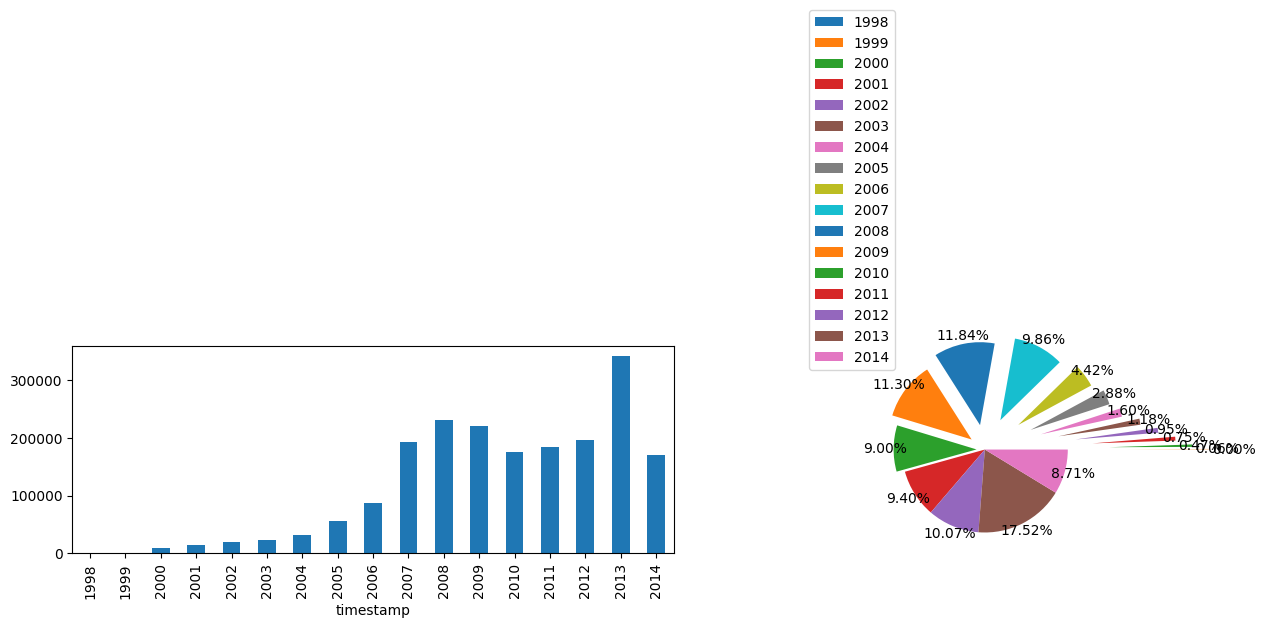

In [49]:
# Visualize the year wise ratings distribution
fig, ax = plt.subplots(1, 2, figsize=(16,6))
year_wise_count = ratings.timestamp.groupby(ratings['timestamp'].dt.year).count()
_ = year_wise_count.plot(kind='bar', ax=ax[0])
explode = (1.9,1.7,1.5,1.3,1.1,0.9,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0,0,0,0)
_ = ax[1].pie(year_wise_count, explode=explode, autopct='%1.2f%%', pctdistance=1.1)
_ = ax[1].legend(labels=year_wise_count.index,bbox_to_anchor=(0.1,0.85))
plt.tight_layout()

**Observaton**:
- The data is collected from 1998 till 2014. And we can see every year the ratings for electronics products are increasing continuously except for an unusual hike in the year 2013 for some unknown reasons.
- After converting to readable format of datatime, it is noticed that this column doesn't contain any time component, just the date component is there.

As there is no time (HHMMSS) component present, it is **not feasible** to somehow make a concept of transaction out of it. Provided the exact hour minute and seconds components are given for each record, grouping them into simillar timestamps and userIds, we could've considered some products to be purchased in a single transaction. Besided this is a product review dataset. Hence we can't apply **Market Basket** analysis. So dropping the timestamp column, which is of no use now.

In [50]:
# Drop the timestamp column
ratings.drop(labels='timestamp', axis=1, inplace=True)
ratings.head()

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.000
1,A2CX7LUOHB2NDG,0321732944,5.000
2,A2NWSAGRHCP8N5,0439886341,1.000
3,A2WNBOD3WNDNKT,0439886341,3.000
4,A1GI0U4ZRJA8WN,0439886341,1.000


In [51]:
# Check the count of unique user and product data
unique_original = (ratings.userId.nunique(), ratings.productId.nunique())
print('Count of unique Users    :', unique_original[0])
print('Count of unique Products :', unique_original[1])

Count of unique Users    : 1346038
Count of unique Products : 110376


In [52]:
# Find the minimum and maximum ratings
print("The Minimum rating is:",ratings.rating.min())
print("The Maximum rating is:",ratings.rating.max())

The Minimum rating is: 1.0
The Maximum rating is: 5.0


Count of observations in each rating:
rating
5.000    1064346
4.000     384646
1.000     237193
3.000     154920
2.000     115015
Name: count, dtype: int64


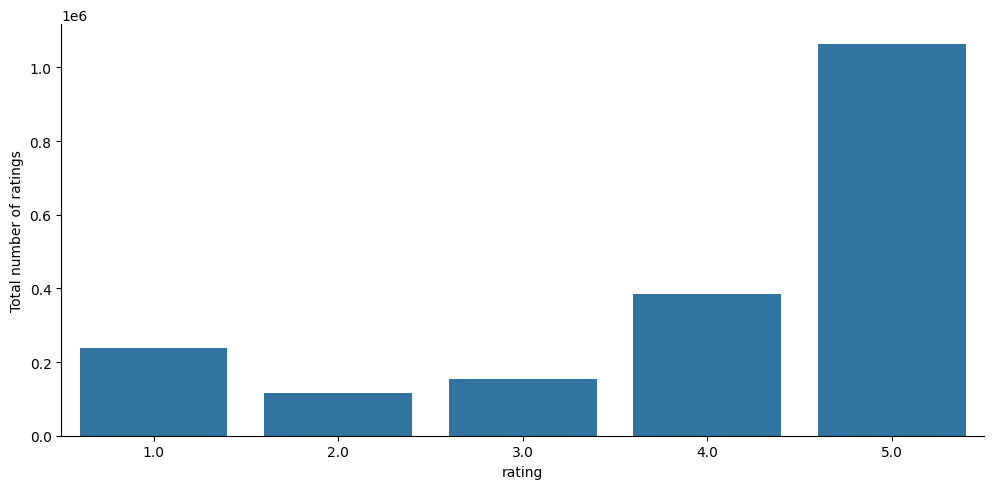

In [53]:
print('Count of observations in each rating:')
print(ratings['rating'].value_counts())

g = sns.catplot(x="rating", data=ratings, aspect=2.0, kind='count')
g.set_ylabels("Total number of ratings")


In [54]:
# Find the unique products under each ratings
ratings.groupby('rating')['productId'].nunique()

rating
1.000    46154
2.000    32754
3.000    39511
4.000    58113
5.000    85528
Name: productId, dtype: int64

**Observations:**
- Extreme high count in rating 5 indicates Amazon delivers good quality products in electronics department.
- Count plot and number of unique product under each rating category shows that there is more frequency under rating 5 followed by rating 4 and rating 1.
- This means ideally people are more sensitive towards extreme experiences. In other words more ratings can be observed when users are extremely satisfied or extremely unsatisfied.
- Users do not bother to rate usually for the average experience with any product, so is the reason rating 2 and 3 are having lesser frequency compared to others.

---
##  Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings)
### Data Sparsity
Many recommender systems run into a problem called the **Cold-Start problem**. Essentially, a user can't be recommended anything because they haven't rated anything! Additionally, if you introduce a new product, nobody has rated it and it can't be recommended. Since we have rating data, we're going to run into either of these problems. Because of this problem, also the mathematical space becomes very much sparse.

If a user has rated one or very few items, how well could a recommender system work? If we have one point of a line, we have no idea which direction the line is going. In the same vein, if we have a user with only one or very few ratings, though we might be able to rule out some items, but it would be very difficult to be confident in our recommendations for that user.

For this reason, I'm going to explore how many ratings have been submitted per user.

In [55]:
# Find the top 10 users based on ratings
most_rated = ratings.userId.value_counts().rename_axis('UserId').reset_index(name='# ratings')
# most_rated = ratings.groupby('userId').size().sort_values(ascending=False)
most_rated.head(10)

,UserId,# ratings
0,A5JLAU2ARJ0BO,439
1,A6FIAB28IS79,252
2,A231WM2Z2JL0U3,249
3,A3OXHLG6DIBRW8,183
4,A680RUE1FDO8B,173
5,A25HBO5V8S8SEA,165
6,AKT8TGIT6VVZ5,155
7,A203OCQQ12MAVT,151
8,AT6CZDCP4TRGA,143
9,A17BUUBOU0598B,142


### Density of the matrix
Density of a matrix can be described as the measure of closeness of datapoints to each other when the matrix is projected into a mathematical space with the no of dimensions equal to the column of the matrix and each row representing a point in that dimensional space. More the density of the matrix more close the data points are in the mathematical space forming a cloud or any other shape. When the data points are scattered far apart in the vector space, such matrix is called as a sparse matrix.

In [56]:
# Find the density of the rating matrix
print('Total observed ratings in the dataset  :', len(ratings))
possible_num_of_ratings = ratings.userId.nunique() * ratings.productId.nunique()
print('Total ratings possible for the dataset :', possible_num_of_ratings)
density = len(ratings) / possible_num_of_ratings * 100
print('Density of the dataset                 : {:4.5f}%'.format(density))

Total observed ratings in the dataset  : 1956120


Total ratings possible for the dataset : 148570290288
Density of the dataset                 : 0.00132%


**Getting rid of users who have rated less than 50 products**, as we can see the **density of the user-item matrix is 0.00039%**

In [57]:
# Drop the users who have rated less than 50 products
ratings = ratings[ratings.userId.isin(most_rated[most_rated['# ratings'] >= 50].UserId)]
print('# unique USERS dropped      :', unique_original[0] - ratings.userId.nunique())
print('# unique ITEMS dropped      :', unique_original[1] - ratings.productId.nunique())


# unique USERS dropped      : 1345919
# unique ITEMS dropped      : 103459


In [58]:
# Find the density of the final matrix
final_ratings_matrix = ratings.pivot(index='userId', columns='productId', values='rating').fillna(0)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
density = len(ratings) / possible_num_of_ratings * 100
print('Density of the dataset                 : {:4.2f}%'.format(density))

Density of the dataset                 : 1.16%


In [59]:
# Divide the dataset in 70:30 ratio
trainset, testset = model_selection.train_test_split(ratings, test_size=0.3, random_state=5)
trainset.head()
testset.head()

,userId,productId,rating
1372057,ARBKYIVNYWK3C,B000TKHBDK,4.000
369936,A3REK3OFONWB1Q,B00017LSPI,5.000
29865,APQQK1V695AUE,B0000226IH,5.000
772820,A2B7BUH8834Y6M,B000BQ7GW8,5.000
288477,AT28RL25Q2OLK,B00009R89V,5.000


,userId,productId,rating
1022801,A1EKSETIBS9ETQ,B000I202FI,5.000
20307,A3EXWV8FNSSFL6,B00001OPJZ,5.000
1316601,A3OXHLG6DIBRW8,B000QW9DPU,5.000
578765,A17BUUBOU0598B,B00070QI1I,4.000
1293126,ARBKYIVNYWK3C,B000PQJGFO,3.000


In [60]:
print('Shape of the training set  :', trainset.shape)
print('Shape of the test set      :', testset.shape)

Shape of the training set  : (6671, 3)
Shape of the test set      : (2859, 3)


Text(0.5, 1.0, 'Training Set')

<Axes: title={'center': 'Training Set'}, xlabel='rating', ylabel='count'>

Text(0.5, 1.0, 'Testing Set')

<Axes: title={'center': 'Testing Set'}, xlabel='rating', ylabel='count'>

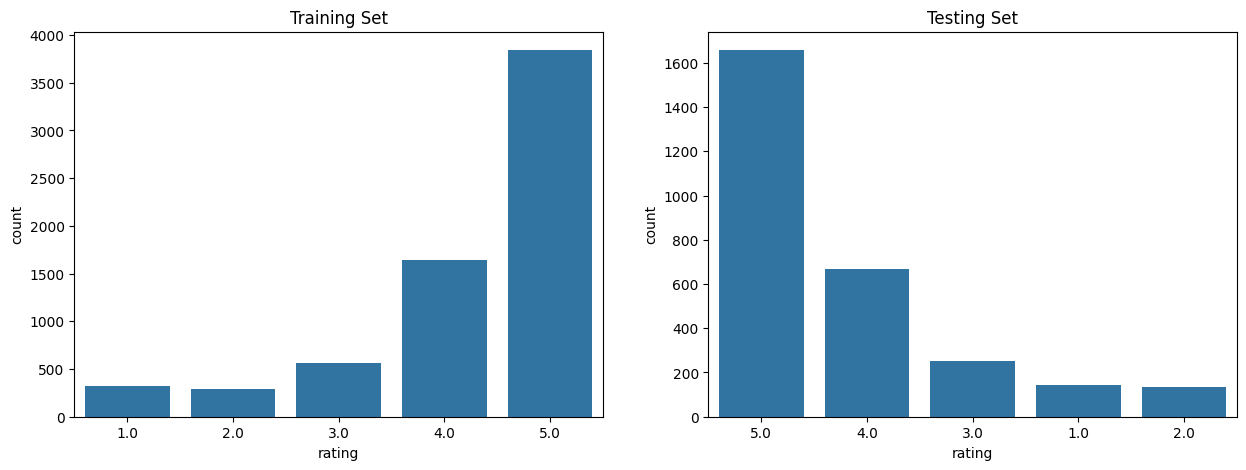

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_title('Training Set')
sns.countplot(x='rating', data=trainset, ax=axes[0])
axes[1].set_title('Testing Set')
sns.countplot(x='rating', data=testset, ax=axes[1], 
              order=testset.rating.value_counts().index)


In [62]:
# Create a method to recommend products based on popularity
def recommend_popular(df, top_n, userId=None):
    # Generate a recommendation rank based upon score 
    df['Rank'] = df['score'].rank(ascending=0, method='first') 
    recommendations = df.sort_values(['score', 'productId'], ascending=[0,1])
    
    # Add UserId column for which the recommendations are being generated 
    if userId:
        recommendations.insert(0,'userId',userId)
    
    # Get the top N recommendations 
    return recommendations.head(top_n)

**Method 1**: UserId count for each unique product as recommended score<br/>
The score for each product in this method is calculated as the sum of the number of users rated. Ratings can be of good and bad. This method doesn't bother about the quality of the ratings recieved, rather just counts how many ratings are present for each product.

In [63]:
#Count of user_id for each unique product as recommendation score 
product_grp = ratings.groupby(['productId']).agg({'userId': 'count'}).reset_index()
product_grp.rename(columns={'userId': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0970407998,1
1,1400532655,2
2,1400599997,1
3,1685560148,1
4,787988002X,1


In [64]:
# Find recommendation for top 10 products
recommend_popular(product_grp, 10)

,productId,score,Rank
4806,B000JMJWV2,20,1.000
424,B00004ZCJE,15,2.000
4913,B000LRMS66,15,3.000
620,B00005LEN4,13,4.000
1432,B00007KDVI,12,5.000
3731,B000AZ57M6,12,6.000
5091,B000N99BBC,12,7.000
5751,B000VX6XL6,11,8.000
6808,B001CHHVCU,11,9.000
207,B00004SB92,10,10.000


---
**Method 2**: Average of ratings for each unique product as recommended score<br/>
The score for each product in this method is calculated as the average of the ratings recieved. This method is better than method 1.

In [65]:
#Count of user_id for each unique product as recommendation score 
product_grp = ratings.groupby(['productId']).agg({'rating': 'mean'}).reset_index()
product_grp.rename(columns={'rating': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0970407998,4.000
1,1400532655,3.000
2,1400599997,1.000
3,1685560148,5.000
4,787988002X,5.000


In [66]:
# Find recommendation for top 10 products
recommend_popular(product_grp, 10)

,productId,score,Rank
3,1685560148,5.000,1.000
4,787988002X,5.000,2.000
8,B000000O48,5.000,3.000
10,B000001OMI,5.000,4.000
13,B00000DM9M,5.000,5.000
14,B00000DM9W,5.000,6.000
16,B00000J03B,5.000,7.000
18,B00000J061,5.000,8.000
19,B00000J08C,5.000,9.000
22,B00000J0E8,5.000,10.000


---
**Method 3**: Sum of ratings for each unique product as recommended score<br/>
The score for each product in this method is calculated as the sum of all ratings recieved. This is practically the best approach to determine the popularity of an item considering only the users ratings are given. This is also preferred over avg (method 2) as average of one 5 star rating is exactly same as the average of more than one 5 star ratings, but the product with more 5 star ratings would be considered as the most popular.

In [67]:
#Count of user_id for each unique product as recommendation score 
product_grp = ratings.groupby(['productId']).agg({'rating': 'sum'}).reset_index()
product_grp.rename(columns={'rating': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0970407998,4.000
1,1400532655,6.000
2,1400599997,1.000
3,1685560148,5.000
4,787988002X,5.000


In [68]:
# Find recommendation for top 10 products
recommend_popular(product_grp, 10)

,productId,score,Rank
4806,B000JMJWV2,94.000,1.000
4913,B000LRMS66,68.000,2.000
424,B00004ZCJE,67.000,3.000
620,B00005LEN4,60.000,4.000
5091,B000N99BBC,60.000,5.000
3731,B000AZ57M6,55.000,6.000
5751,B000VX6XL6,51.000,7.000
6043,B00119T6NQ,46.000,8.000
6590,B0019EHU8G,45.000,9.000
207,B00004SB92,43.000,10.000


In [69]:
# Find recommendation for couple of users
find_recom = {'A197T2N6RU7K56': 7, 
              'A1FR68QH6Z4YZM': 7, 
              'A10AFVU66A79Y1': 7}   # This list is user, top_n recommendation dict.
for user in find_recom:
    print("Top %d recommendations for the userId: %s" %(find_recom[user],user))
    recommend_popular(product_grp,find_recom[user],user)
    print("\n") 

Top 7 recommendations for the userId: A197T2N6RU7K56


,userId,productId,score,Rank
4806,A197T2N6RU7K56,B000JMJWV2,94.000,1.000
4913,A197T2N6RU7K56,B000LRMS66,68.000,2.000
424,A197T2N6RU7K56,B00004ZCJE,67.000,3.000
620,A197T2N6RU7K56,B00005LEN4,60.000,4.000
5091,A197T2N6RU7K56,B000N99BBC,60.000,5.000
3731,A197T2N6RU7K56,B000AZ57M6,55.000,6.000
5751,A197T2N6RU7K56,B000VX6XL6,51.000,7.000




Top 7 recommendations for the userId: A1FR68QH6Z4YZM


,userId,productId,score,Rank
4806,A1FR68QH6Z4YZM,B000JMJWV2,94.000,1.000
4913,A1FR68QH6Z4YZM,B000LRMS66,68.000,2.000
424,A1FR68QH6Z4YZM,B00004ZCJE,67.000,3.000
620,A1FR68QH6Z4YZM,B00005LEN4,60.000,4.000
5091,A1FR68QH6Z4YZM,B000N99BBC,60.000,5.000
3731,A1FR68QH6Z4YZM,B000AZ57M6,55.000,6.000
5751,A1FR68QH6Z4YZM,B000VX6XL6,51.000,7.000




Top 7 recommendations for the userId: A10AFVU66A79Y1


,userId,productId,score,Rank
4806,A10AFVU66A79Y1,B000JMJWV2,94.000,1.000
4913,A10AFVU66A79Y1,B000LRMS66,68.000,2.000
424,A10AFVU66A79Y1,B00004ZCJE,67.000,3.000
620,A10AFVU66A79Y1,B00005LEN4,60.000,4.000
5091,A10AFVU66A79Y1,B000N99BBC,60.000,5.000
3731,A10AFVU66A79Y1,B000AZ57M6,55.000,6.000
5751,A10AFVU66A79Y1,B000VX6XL6,51.000,7.000


**Observations:**
- Popularity recommender models works based on the popularity of products.
- The products with highest number of ratings gets recommended irrespective of user's interest. This is the model used as a basic recommendation even when the user is not even logged into Amazon.
- So is observed above that all the 3 users recieved the same recommendations i.e the top n rated products under Electronics category.

---
##  Build Collaborative Filtering model
### Collaborative Filtering
Collaborative filtering is the process of filtering out information or patterns using techniques involving collaboration among multiple agents, viewpoints, data sources, etc.This is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a matter, A is more likely to have B's opinion on a different matter than that of a randomly chosen person.


**Nearest Neighborhood** - The standard method of Collaborative Filtering is known as Nearest Neighborhood algorithm. 

**Types of Collaborative Filtering (CF)**
- Item Based Collaborative Filtering (IBCF)
  - Compute similarity between Items
- User Based Collaborative Filtering (UBCF)
  - Compute similarity between Users
  
**IBCF vs. UBCF**
- IBCF is more efficient than UBCF
- Typical applications involve far more Users than Items. Hence Similarity matrix for IBCF is more compact than UBCF
- Similarity estimates between items is also more likely to converge over time than similarity between users. Hence the similarities can be pre computed and cached unlike similarity between users that need to be dynamically computed at every certain interval.
- However, the IBCF recommendations tend to be more conservative than UBCF

**Similarity Metrics**

- **Cosine Similarity**: Similarity is the cosine of the angle between the 2 item vectors represented by:
$$Cosine\;Similarity:CosSim(x,y)=\frac{\sum_i{x_iy_i}}{\sqrt{\sum{(x_i)^2}}\sqrt{\sum{(y_i)^2}}}=\frac{\langle x, y \rangle}{\|x\|\|y\|}$$

### User Based Collaborative Filtering (UBCF)
This algorithm first finds the similarity score between users. Based on this similarity score, it then picks out the most similar users and recommends products which these similar users have liked or bought previously.
### Item Based Collaborative Filtering (IBCF)
This algorithm first finds the similarity score between items. Based on this similarity score, it then picks out the most similar items and recommends that to the user which these similar items have been liked or bought previously.

First step is to create the sparse matrix. Let's attempt both UBCF and IBCF consecutively.

In [70]:
# Create the User-Item sparse matrix
user_item = ratings.pivot(index='userId', columns='productId', values='rating').fillna(0)
print('Shape of User-Item sparse matrix:', user_item.shape)
user_item.head()

Shape of User-Item sparse matrix: (119, 6917)


productId,0970407998,1400532655,1400599997,1685560148,787988002X,9043413585,9981719005,998376234X,B000000O48,B000001OL6,...,B001E2HKL0,B001E2T6Y4,B001E3XLZS,B001E45THA,B001E5DOWG,B001E67264,B001E6ZQ08,B001E71H5K,B001E78UQY,B001E7VZ66
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A11ED8O95W2103,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A11KZ906QD08C5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000
A12DLJESJKM1OQ,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A1435P5AMCPB3X,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [71]:
# Create the Item-User sparse matrix
item_user = ratings.pivot(index='productId', columns='userId', values='rating').fillna(0)
print('Shape of Item-User sparse matrix:', item_user.shape)
item_user.head()

Shape of Item-User sparse matrix: (6917, 119)


userId,A11D1KHM7DVOQK,A11ED8O95W2103,A11KZ906QD08C5,A12DLJESJKM1OQ,A1435P5AMCPB3X,A149RNR5RH19YY,A14JBDSWKPKTZA,A15QYHQH80W30L,A17BUUBOU0598B,A17HMM1M7T9PJ1,...,AN81JUYW2SL24,AOEAD7DPLZE53,APQQK1V695AUE,ARBKYIVNYWK3C,ARXU3FESTWMJJ,AT28RL25Q2OLK,AT2J7H5TRZM8Z,AT6CZDCP4TRGA,ATDE9JYCPI0L1,AWPODHOB4GFWL
productId,,,,,,,,,,,,,,,,,,,,,
0970407998,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1400532655,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1400599997,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1685560148,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
787988002X,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Now, we will calculate the similarity. We can use the cosine_similarity function from sklearn to calculate the cosine similarity.

In [72]:
# Calculate the user-user similarity
user_similarity = cosine_similarity(user_item)
np.fill_diagonal(user_similarity, 0)
user_similarity_df = pd.DataFrame(user_similarity,index=user_item.index, columns=user_item.index)
user_similarity_df.tail()

userId,A11D1KHM7DVOQK,A11ED8O95W2103,A11KZ906QD08C5,A12DLJESJKM1OQ,A1435P5AMCPB3X,A149RNR5RH19YY,A14JBDSWKPKTZA,A15QYHQH80W30L,A17BUUBOU0598B,A17HMM1M7T9PJ1,...,AN81JUYW2SL24,AOEAD7DPLZE53,APQQK1V695AUE,ARBKYIVNYWK3C,ARXU3FESTWMJJ,AT28RL25Q2OLK,AT2J7H5TRZM8Z,AT6CZDCP4TRGA,ATDE9JYCPI0L1,AWPODHOB4GFWL
userId,,,,,,,,,,,,,,,,,,,,,
AT28RL25Q2OLK,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.060,0.000,0.030,...,0.000,0.000,0.000,0.000,0.020,0.000,0.000,0.000,0.000,0.000
AT2J7H5TRZM8Z,0.000,0.000,0.000,0.039,0.011,0.002,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.043,0.000,0.000,0.000,0.000,0.000
AT6CZDCP4TRGA,0.018,0.000,0.024,0.000,0.000,0.002,0.003,0.003,0.025,0.000,...,0.000,0.000,0.000,0.014,0.000,0.000,0.000,0.000,0.000,0.010
ATDE9JYCPI0L1,0.000,0.000,0.008,0.000,0.000,0.000,0.024,0.000,0.000,0.000,...,0.024,0.000,0.047,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AWPODHOB4GFWL,0.009,0.000,0.021,0.000,0.011,0.012,0.074,0.000,0.095,0.012,...,0.026,0.017,0.000,0.038,0.027,0.000,0.000,0.010,0.000,0.000


In [73]:
# Calculate the item-item similarity
item_similarity = cosine_similarity(item_user)
np.fill_diagonal(item_similarity, 0)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user.index, columns=item_user.index)


Now that we have both the similiarity matrices in our hand, let's see the n-Neighborhood.

In [74]:
# Method to find top N neighbors
def find_n_neighbors(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(axis=1, func=lambda x: pd.Series(x.sort_values(ascending=False).iloc[:n].index,
                                                   index=['top{}'.format(i) for i in range(1, n+1)]))
    return df

In [75]:
# Find 10 neighbors of each user
user_10_neighbors = find_n_neighbors(user_similarity_df, 10)
user_10_neighbors.head(10)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
userId,,,,,,,,,,
A11D1KHM7DVOQK,A7EJERNB7IK3Z,A1VQHH85U7PX0,AGXV8E7XK9J6H,A3QQGPI3CTV9SX,A2R6RA8FRBS608,A5JLAU2ARJ0BO,A25FL6VLD7S23S,AT6CZDCP4TRGA,A3W4D8XOGLWUN5,A6VPK7X53QNAQ
A11ED8O95W2103,A3NCIN6TNL0MGA,A1RPTVW5VEOSI,A1T1YSCDW0PD25,A291XTI6NO7DEG,A2WLNSZ9U0T1S3,A31N0XY2UTB25C,A3QMJMTLJC34QC,ABVYGB2TKBO8F,A2HPJKM7L4EOQB,A1X1CEGHTHMBL1
A11KZ906QD08C5,A5KMMY627T3W,AGXV8E7XK9J6H,A2UOHALGF2X77Q,A1L64KDYO5BOJA,A1VQHH85U7PX0,A680RUE1FDO8B,APQQK1V695AUE,AOEAD7DPLZE53,A7EJERNB7IK3Z,A36A1ZYZH8568P
A12DLJESJKM1OQ,ABH9D1TEOJ56E,AGHZXQL9F94T9,A2SKEQT0WTB954,A5JLAU2ARJ0BO,AT2J7H5TRZM8Z,A231WM2Z2JL0U3,A1435P5AMCPB3X,A1CPRP3VFJRS1R,A1F9Z42CFF9IAY,A4WEZJOIZIV4U
A1435P5AMCPB3X,A38QEATH3NODFM,A3W4D8XOGLWUN5,A1EH2S92FHWZRP,A12DLJESJKM1OQ,A1F9Z42CFF9IAY,A1ZM846Y7AUYD,A5JLAU2ARJ0BO,ADLVFFE4VBT8,A2Y739CRM15WDL,ABVYGB2TKBO8F
A149RNR5RH19YY,A1T1YSCDW0PD25,AD0J5KK4WQXNS,A36A1ZYZH8568P,A3OXHLG6DIBRW8,A14JBDSWKPKTZA,A32O5FZH994CNY,A1CPRP3VFJRS1R,A1UEL5C1N6E5SE,A680RUE1FDO8B,A3CW0ZLUO5X2B1
A14JBDSWKPKTZA,AN81JUYW2SL24,A6VPK7X53QNAQ,A17BUUBOU0598B,AWPODHOB4GFWL,A3Q4TYJVAM4IRM,A23GFTVIETX7DS,A1CPRP3VFJRS1R,A32O5FZH994CNY,A231WM2Z2JL0U3,AEWYUPCNDV7HY
A15QYHQH80W30L,A7QMQBGJ2TCQG,A38KK0SZYEH5UD,A3FPSY1M6G7XIB,A1NNMOD9H36Q8E,A3T7V207KRDE2O,A2XRMQA6PJ5ZJ8,A3E68EBGXTWDNP,A25FL6VLD7S23S,AT28RL25Q2OLK,AC6Z7DP1Z5GHD
A17BUUBOU0598B,AEWYUPCNDV7HY,A23GFTVIETX7DS,AWPODHOB4GFWL,A6VPK7X53QNAQ,AGVWTYW0ULXHT,A14JBDSWKPKTZA,A2WLNSZ9U0T1S3,ARXU3FESTWMJJ,A3Q4TYJVAM4IRM,A1ZM846Y7AUYD


In [76]:
# Find 10 neighbors of each item
item_10_neighbors = find_n_neighbors(item_similarity_df, 10)
item_10_neighbors.head(10)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
productId,,,,,,,,,,
0970407998,B00009R8D3,B000WOT6O0,B0000BZL8X,B0007TSYCK,B00123Q8YQ,B000BM66V4,B000X7SNVI,B000XALL8W,B00078Y24K,B001ADUCTU
1400532655,B0009AFX0S,B0001D3K3A,B0001CFSX6,B000093IRC,B0000A0VAF,B00065ZK3G,B00065ZK4A,B0009IU4OA,B0001BXCFS,B00008CMMH
1400599997,B00000JI2C,B00000J3Q1,B0000CE3CE,B000BQN4IS,B00128EJ74,B00003006X,B00004SA32,B00005A0R8,B001DCDYHA,B0000D8IRV
1685560148,B0007LQ286,B000ASTKWQ,B0000BZO7U,B000EFIJVI,B00091S0WA,B000IWL77U,B000XGMUYK,B000UN8MKM,B000FNBI5S,B000TM1O3Q
787988002X,B0001CKQF6,B000ROKSN8,B000WS5VNQ,B0001W7TU6,B000NO6KWU,B000MVBHRW,B000NO5OYA,B000H9AF9K,B0013AHADQ,B000FTHLIA
9043413585,B000BUK7KW,B000VEPC6W,B00020E4QO,B000EON3WY,B0011E4N5C,B00188RK9M,B000I81KS0,B00017LRF4,B00004Z64Y,B00181C9LS
9981719005,B000J38QBS,B000RPTUQS,B001250KX4,B000Y138EK,B001CJNWX0,B001CJRKDS,B000Y8EXSS,B001CS51DK,B00006343P,B000BT94UW
998376234X,B00005NPWK,B000TUGSI4,B000P6664I,B000Q7IA5E,B0006BGV2Y,B000MEURMK,B00127ZES8,B001CD160M,B00154MCKQ,B000E9ZQBU
B000000O48,B0000645V1,B000067S9Y,B00006ANXP,B0000326O1,B000A3WS20,B000063WP0,B000063W55,B000GF2J76,B00009V3MM,B00005V9B5


Let's verify the similarity in both item and user base to find out if our calculatios are correct

In [77]:
def get_users_similar_products(user1, user2):
    common_products = ratings[ratings.userId == user1].merge(
    ratings[ratings.userId == user2],
    on = "productId",
    how = "inner" )
    return common_products[['rating_x', 'rating_y', 'productId']].head()

In [78]:
# Check the similarity of two users
get_users_similar_products('A11D1KHM7DVOQK', 'A7EJERNB7IK3Z')

,rating_x,rating_y,productId
0,4.000,4.000,B000092YPR
1,5.000,3.000,B0001F22PA
2,5.000,3.000,B00061IYFQ


item_similarity and user_similarity are item-item and user-user similarity matrix in an array form respectively. The next step is to make predictions based on these similarities. Let’s define a function to do just that.

Finally, we will make predictions based on user similarity and item similarity and recommend product based on similarity.

In [80]:
# Predict the ratings for both UBCF and IBCF
# Compute user-based collaborative filtering predictions
mean_user_rating = user_item.mean(axis=1)
mean_user_rating = mean_user_rating.values.reshape(-1, 1)
ratings_diff = user_item.sub(mean_user_rating, axis=0)
user_prediction = mean_user_rating + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T
user_prediction = pd.DataFrame(user_prediction, index=user_item.index, columns=user_item.columns)
user_prediction.head()

# Compute item-based collaborative filtering predictions
item_prediction = user_item.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])



productId,0970407998,1400532655,1400599997,1685560148,787988002X,9043413585,9981719005,998376234X,B000000O48,B000001OL6,...,B001E2HKL0,B001E2T6Y4,B001E3XLZS,B001E45THA,B001E5DOWG,B001E67264,B001E6ZQ08,B001E71H5K,B001E78UQY,B001E7VZ66
userId,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,-0.010,0.031,-0.010,-0.010,0.262,0.203,-0.010,-0.010,0.142,0.159,...,-0.010,-0.010,-0.010,-0.010,0.169,0.053,0.385,-0.010,-0.010,-0.010
A11ED8O95W2103,-0.020,0.014,-0.020,0.164,-0.020,-0.020,-0.020,-0.020,-0.020,-0.020,...,0.156,-0.020,-0.020,0.054,-0.020,-0.020,-0.020,-0.020,0.024,-0.020
A11KZ906QD08C5,0.043,0.013,0.009,0.057,0.009,0.097,0.032,0.017,0.009,0.009,...,0.067,0.009,0.105,0.039,0.009,0.045,0.128,0.197,0.074,0.009
A12DLJESJKM1OQ,-0.015,0.146,-0.015,-0.015,-0.015,-0.015,-0.015,-0.015,-0.015,-0.015,...,-0.015,-0.015,-0.015,-0.015,-0.015,-0.015,-0.015,0.089,-0.015,-0.015
A1435P5AMCPB3X,0.006,0.034,0.006,0.119,0.087,0.006,0.083,0.018,0.006,0.006,...,0.006,0.006,0.006,0.006,0.103,0.056,0.047,0.093,0.090,0.089


Time taken 0.59s to find out the user and item prediction


In [81]:
# Method to Recommend the items with the highest predicted ratings
def recommend_items(userId, orig_df, preds_df, top_n):
    # Get and sort the user's ratings
    sorted_user_ratings = orig_df.loc[userId].sort_values(ascending=False) #sorted_user_ratings
    sorted_user_predictions = preds_df.loc[userId].sort_values(ascending=False) #sorted_user_predictions

    # Prepare recommendations
    recommendations = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    recommendations.index.name = 'Recommended Items'
    recommendations.columns = ['user_ratings', 'user_predictions']
    
    # Take the products which user has NOT rated
    recommendations = recommendations.loc[recommendations.user_ratings == 0] 
    recommendations = recommendations.sort_values('user_predictions', ascending=False)
    return recommendations.head(top_n)

In [82]:
# Find recommendation for couple of users using UBCF
find_recom = {'A11D1KHM7DVOQK': 6, 
              'A11ED8O95W2103': 6, 
              }   # This list is user, top_n recommendation dict.
for user in find_recom:
    print("Top %d recommendations for the userId: %s" %(find_recom[user],user))
    recommend_items(user, user_item, user_prediction, find_recom[user])
    print("\n") 

Top 6 recommendations for the userId: A11D1KHM7DVOQK


,user_ratings,user_predictions
Recommended Items,,
B0007QKMQY,0.000,0.821
B00004ZCJE,0.000,0.799
B000FOYMKU,0.000,0.767
B000VX6XL6,0.000,0.755
B00004Z5M1,0.000,0.725
B000V1MLBE,0.000,0.721




Top 6 recommendations for the userId: A11ED8O95W2103


,user_ratings,user_predictions
Recommended Items,,
B001E1Y5O6,0.000,0.804
B00004SB92,0.000,0.665
B000G6M91G,0.000,0.620
B000L47AHG,0.000,0.616
B001AQWLTQ,0.000,0.611
B000N99BBC,0.000,0.595
